<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Seventh_Model_von_Mises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q
 
import numpy as np
import tensorflow as tf
import keras
import pickle
import spektral
 
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor
 
from keras import backend as K
 
from time import time
 
 
from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv
from spektral import transforms
 
from tqdm.notebook import tqdm
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
 
PI = np.pi
 
 
# Lifehack
true = True
false = False

     |████████████████████████████████| 112kB 8.7MB/s 


In [ ]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

     |████████████████████████████████| 2.0MB 8.7MB/s 
     |████████████████████████████████| 163kB 45.3MB/s 
     |████████████████████████████████| 133kB 37.6MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
################################################################################
# LOAD DATA
################################################################################

class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      # e,a,z = g["y"]
      # g["y"] = [transformer['energy_log10'].inverse_transform([[e]])[0][0],transformer['azimuth'].inverse_transform([[a]])[0][0]-PI,transformer['zenith'].inverse_transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])

Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)


In [ ]:
from tensorflow.math import sin as tsin
from tensorflow.math import cos as tcos
from tensorflow.math import log as tln


def von_mises_loss(target,predictions):
  predictions = tf.cast(predictions,"float64")
  azi, zeni = predictions[:,0], predictions[:,1]
  kappa = tf.math.abs(predictions[:,2])

  azi_true, zeni_true = target[:,1],target[:,2]

  t1 = tsin(zeni_true+azi_true+zeni)
  t2 = tsin(zeni_true - azi_true + azi)
  t3 = tcos(zeni_true - zeni)
  t4 = tcos(zeni_true + zeni)

  cosOmega = 0.5*tf.math.abs(tsin(zeni))*(t1+t2) + 0.5*(t3 + t4)

  kappa = tf.where(tf.math.equal(kappa,tf.zeros_like(kappa)), tf.ones_like(kappa)*0.00001, kappa)

  NLLH = -kappa*cosOmega-tln(kappa) + kappa + tln(1-tf.math.exp(-2*kappa))
  
  N = tf.reduce_sum(tf.cast(tf.math.is_nan(NLLH), tf.float32))

  NLLH = tf.where(tf.math.is_nan(NLLH), tf.math.multiply(tf.ones_like(NLLH),10), NLLH)

  # if N == batch_size:
    # tf.print("Oh no! All are NaN")

  return tf.reduce_mean(NLLH)

loss_fn = von_mises_loss


def custom_acc(target,predictions):
  predictions = tf.cast(predictions,"float64")
  aziguess = predictions[:,0]
  azi = tf.minimum( tf.abs(target[:,1] - aziguess) , tf.abs(tf.abs(target[:,1] - aziguess) - 2*PI))
  
  zeniguess = predictions[:,1]
  zeni = tf.minimum( tf.abs(target[:,2] - zeniguess) , tf.abs(tf.abs(target[:,2] - zeniguess) - 2*PI))

  sigma = tf.math.sqrt(tf.math.reciprocal_no_nan(predictions[:,2]))

  return tf.reduce_mean(azi),tf.reduce_mean(zeni),tf.reduce_mean(sigma)

acc_fn = custom_acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs


def lr_schedule(start_lr,epoch,total_epochs):
  if epoch < total_epochs//4:
    return start_lr*(1+epoch/(total_epochs//4))
  return 2*start_lr/(10*epoch/total_epochs)

In [ ]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  16#@param {type: "number"}
 
# one-variable network size changer
network_size =  64#@param {type: "number"}
 
learning_rate =   1e-5#@param {type: "number"}
 
training_epochs = 30 #@param {type: "slider", min: 10, max: 200}
 
early_stopping_rounds =  3#@param {type: "number"}
 
dropout_rate = 0 #@param {type: "number"}
 
loss_function = "von_mises_fisher"  #@param ['custom_loss',"rasmus_loss","binary_cross_entropy","von_mises_fisher"]
 
config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Broadening CNN - short but wide",
        "network_size": network_size,
        "dropout_rate": dropout_rate,
        "dataset": "MuonGun",
        "early_stopping_rounds": early_stopping_rounds,
      }
 
epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs

In [ ]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = 3  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, shuffle=True)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)


#Scaled sigmoid
def skrrt(x):
  return tf.math.divide_no_nan(2*PI,(1+tf.math.exp(-x)))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'skrrt_activation': Activation(skrrt)})

class model_class(Model):
  def __init__(self):
    super().__init__()
    
    self.preprocess = transforms.layer_preprocess.LayerPreprocess(GCNConv)

    # self.inp = ECCConv(network_size//4)

    self.steps = [2**(i+1) for i in range(3)]
    self.convs = [GCNConv(network_size*s,activation="gelu") for s in self.steps]

    self.maxpool = GlobalMaxPool()
    self.avgpool = GlobalAvgPool()
    self.sumpool = GlobalSumPool()

    self.denses = [Dense(network_size*s,activation= "gelu") for s in self.steps[::-1]]
    self.dropouts = [Dropout(dropout_rate) for s in self.steps]

    # self.splitdenses = [Dense(network_size,activation= "gelu") for s in range(n_out)]
    # self.splitdensessmall = [Dense(network_size//2,activation= "gelu") for s in range(n_out)]
    
    # self.normalizations = [BatchNormalization() for s in self.steps]

    self.out = Dense(n_out)
    # self.outact = Dense(n_out,activation=Activation("skrrt_activation"))

    # self.oneouts = [Dense(1) for d in range(n_out)]

  def call(self, inputs, training = False):

    x, a, i = inputs
    # a, e    = self.generate_edge_features(x, a) # NEXT STEP is implementing this for myself
    # x = self.inp([x,a,e])
    # a = self.preprocess(a)
    for conv in self.convs:
      x = conv([x,a])
    
    
    xm = self.maxpool([x,i])
    xa = self.avgpool([x,i])
    xs = self.sumpool([x,i])

    x = tf.concat([xm, xa, xs], axis = 1) 


    for dense, dropout in zip(self.denses,self.dropouts):
      # x = norm(x) # ,training = training # batch_normalization is broken in curretn keras
      x = dense(x)
      x = dropout(x,training = training)


    # xs = [x for a in range(n_out)]
    # for i, out in enumerate(self.oneouts):
      # xs[i] = out(xs[i])
    # for i, (sd, sds, out) in enumerate(zip(self.splitdenses,self.splitdensessmall,self.outs)):
    #   xs[i] = out(sds(sd(xs[i])))
    out = self.out(x)
    return out
    # return tf.concat([oute, outa1,outa2, outz1,outz2], axis = 1) 


  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

# Build model
model = model_class()

opt = Adam(lr=learning_rate,clipvalue=1)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
# loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
# acc_fn = custom_acc


model.compile()
# model.build()
# fit(train_loader)

In [ ]:

################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc

loss_fn = von_mises_loss
acc_fn = custom_acc


def fit(train_loader,logwandb = False):
  if logwandb:
    run = wandb.init(project='IceCube von Mises',config = config)

  current_batch = 0
  model_loss = []
  model_acc = []
  vali_loss = []
  epoch = 0

  earlystop = 0
  should_stop = False

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True, ncols='70%')
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_loss = 0
  
  for batch in train_loader:
      if should_stop:
        print("Ending fitting because of early stopping")
        break

      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)

      if step%100 == 0:
        t.set_description(f'Current loss {np.mean(model_loss):.3} | Working on epoch {epoch} of {epochs}:')

      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results for epoch {epoch} of {epochs}:')
          vali_acc = []
          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            valoss, vaacc = validate(vali_inputs,vali_target)
            vali_acc.append(vaacc)
            vali_loss.append(valoss)
          va = np.mean(vali_loss)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,abs(last_loss))
          last_loss = m_loss

          s = "Train loss: {} - Loss change {:+.3f}% | Validation loss {} | Epoch: {}".format(m_loss, change*100,va, epoch)
          t.write(s)
          vvaa = np.array(vali_acc)
          s = "Validation: Zenith accuracy {:.3} | Azimuth accuracy {:.3} | Average uncertainty {:.3}".format(np.mean(vvaa[:,0]),np.mean(vvaa[:,1]),np.mean(vvaa[:,2]))
          t.write(s)

          if m_loss < va:
            if earlystop < early_stopping_rounds:
              earlystop += 1
            else:
              should_stop = True
          else:
            earlystop = 0



          if epoch%10 == 0:
            # maybe write a saving state here
            pass

          # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])

          # if epoch%5 == 0 and epoch != 0:
            # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
            # pass
          # else:
            # pb = model(inputs, training=False)
            # tar = target



          if logwandb:
            wandb.log({
                      "train_loss": m_loss,
                      "validation_loss": va,
                      "zenith_validation_accuracy": np.mean(vvaa[:,0]),
                      "azimuth_validation_accuracy": np.mean(vvaa[:,1]),
                      "average_uncertainty": np.mean(vvaa[:,2])
                       
                      })




          model_loss = []
          model_acc = []
          vali_loss = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()

          epoch += 1


          K.set_value(model.optimizer.learning_rate, lr_schedule(learning_rate,epoch,epochs))

In [8]:
logwandb = False

fit(train_loader,logwandb = logwandb)

print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"
 

if logwandb:
  pth = save_path + f"/{wandb.run.name}-run"
  wandb.run.finish()  
else:
  pth = save_path + "/VonMises"

model.save(pth)

Train loss: -1.2860234516117108 - Loss change -128602345.161% | Validation loss -2.355788788791218 | Epoch: 0
Validation: Zenith accuracy 2.25 | Azimuth accuracy 1.58 | Average uncertainty nan
Train loss: -2.687914746055582 - Loss change -109.010% | Validation loss -3.2139072704437965 | Epoch: 1
Validation: Zenith accuracy 1.71 | Azimuth accuracy 1.39 | Average uncertainty nan
Train loss: -2.9167686489066185 - Loss change -8.514% | Validation loss -3.554490424016179 | Epoch: 2
Validation: Zenith accuracy 1.83 | Azimuth accuracy 1.4 | Average uncertainty nan
Train loss: -3.7980400377494568 - Loss change -30.214% | Validation loss -5.492011020443416 | Epoch: 3
Validation: Zenith accuracy 1.81 | Azimuth accuracy 1.07 | Average uncertainty nan
Train loss: -5.335186114603328 - Loss change -40.472% | Validation loss -3.4137943965865065 | Epoch: 4
Validation: Zenith accuracy 1.75 | Azimuth accuracy 1.24 | Average uncertainty nan
Train loss: -6.070990893975436 - Loss change -13.792% | Validati

In [9]:
   test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)

import pandas as pd

truths, guesses = [],[]

for batch in tqdm(test_loader,total = test_loader.steps_per_epoch * test_epochs):
  input, target = batch
  input = scale_inputs(input)
  guess = model(input, training = False)
  truths.append(target)
  guesses.append(guess)

guesses = np.array(guesses)
guesses = guesses.reshape((1250*32,3))

truths = np.array(truths)
truths = truths.reshape((1250*32,3))

guesses = pd.DataFrame(guesses,columns = ["azimuth","zenith","error"])
truths = pd.DataFrame(truths,columns = ["energy","azimuth","zenith"])

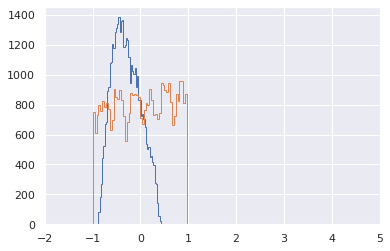

In [28]:
g = guesses.error
t = g < np.max(truths.azimuth)
# g = g[t]

plt.hist(truths.zenith,50,histtype="step")
plt.hist(truths.azimuth,50,histtype="step")
plt.xlim(-2,5)
plt.show()